In [1]:
import torch

import numpy as np
import pandas as pd
from models.mlp import MLP

from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv("./dataset/exported/data_176_cleaned/train.csv")
test = pd.read_csv("./dataset/exported/data_176_cleaned/test.csv")

all_data = pd.concat([train, test], axis=0)

In [3]:
real_led_6 = test["led_6"]

In [4]:
# Times scalar and adds noise
test["led_6"] = test["led_6"]*0.25 + np.random.normal(0, 0.01, len(test["led_6"]))

In [5]:
X = torch.from_numpy(test.drop(["x", "y"], axis="columns").to_numpy()).to(dtype=torch.float32)
y = torch.from_numpy(test[["x", "y"]].to_numpy()).to(dtype=torch.float32)

In [6]:
model = MLP(normalize=True, seed=42, epochs=25)
model.load("./saved_runs/MLP-TINY-NORMALISE-1747596375.pth")

In [7]:
predicted = ((model.predict(X) / 10).round()*10).to(dtype=torch.int64)

In [8]:
error = torch.norm(predicted - y, dim=1).mean()
print(f"Average error: {error.item()}")

Average error: 41.840118408203125


In [9]:
led_6 = 0
n = 0
random_idx = np.random.randint(0, len(test), 1000)
for i in tqdm(range(1000)):
    i = random_idx[i]
    predicted_i = predicted[i, :]
    
    first = all_data[all_data["x"] == predicted_i[0].item()]
    second = first[first["y"] == predicted_i[1].item()]
    
    if len(second["led_6"]) == 0 or X[i, 6] == 0:
        continue

    led_6 += second["led_6"].item() / X[i, 6]
    n += 1

predicted_scalar = led_6/n
print(f"Predicted scalar: {predicted_scalar}")

100%|██████████| 1000/1000 [00:00<00:00, 1036.04it/s]

Predicted scalar: 1.440443754196167


100%|██████████| 1000/1000 [00:00<00:00, 1251.08it/s]


Correction scalar from regression: 0.29687709134011053


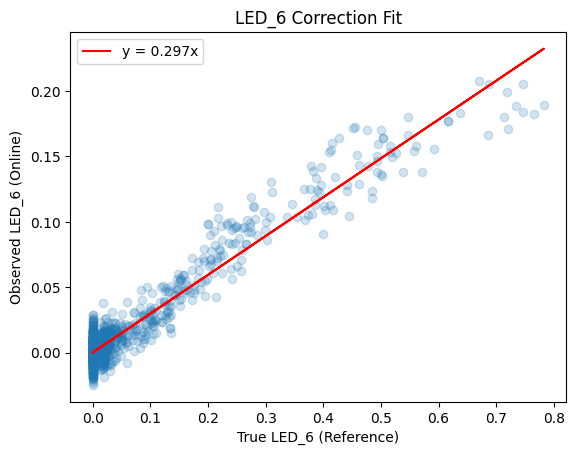

In [10]:
random_idx = np.random.randint(0, len(test), 1000)
x_vals = []
y_vals = []
for i in tqdm(range(1000)):
    i = random_idx[i]
    predicted_i = predicted[i, :]
    
    first = all_data[all_data["x"] == predicted_i[0].item()]
    second = first[first["y"] == predicted_i[1].item()]

    if len(second["led_6"]) == 0:
        continue

    x_vals.append(second["led_6"].item())
    y_vals.append(X[i, 6].item())

x_vals = np.array(x_vals)
y_vals = np.array(y_vals)

a = np.polyfit(x_vals, y_vals, 1)[0]
print(f"Correction scalar from regression: {a}")

plt.plot(x_vals, a * x_vals, color="red", label=f"y = {a:.3f}x")

plt.scatter(x_vals, y_vals, alpha=0.2)
plt.xlabel("True LED_6 (Reference)")
plt.ylabel("Observed LED_6 (Online)")
plt.legend()
plt.title("LED_6 Correction Fit")
plt.show()

RANSAC fit: y = 0.2506 * x + -0.0057
Scalar = 0.2506


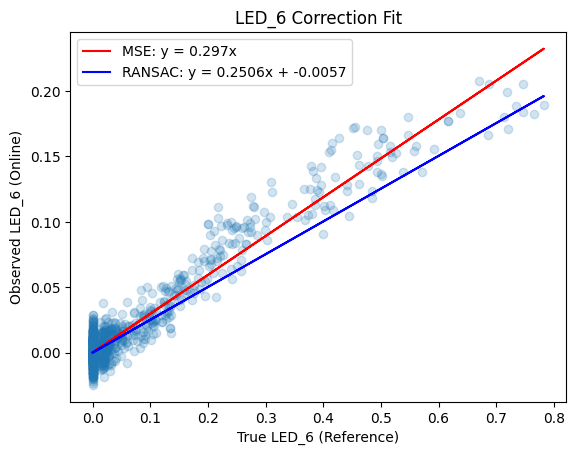

In [11]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# From earlier steps
observed = test["led_6"].values.reshape(-1, 1)   # dimmed, used in model
true = real_led_6.values                         # actual values before dimming

# Optional: filter out very low values to avoid divide-by-zero or noise
mask = (observed.flatten() > 1e-3) & (true > 1e-3)
X_filtered = observed[mask]
y_filtered = true[mask]

# Fit robust regression using RANSAC
base_model = LinearRegression()
ransac = RANSACRegressor(base_model, residual_threshold=1.0, max_trials=100)
ransac.fit(X_filtered, y_filtered)

# Get the fitted slope and intercept
slope = ransac.estimator_.coef_[0]
intercept = ransac.estimator_.intercept_

print(f"RANSAC fit: y = {1/slope:.4f} * x + {intercept:.4f}")
print(f"Scalar = {1/slope:.4f}")

plt.plot(x_vals, a * x_vals, color="red", label=f"MSE: y = {a:.3f}x")
plt.plot(x_vals, (1/slope) * x_vals, color="blue", label=f"RANSAC: y = {1/slope:.4f}x + {intercept:.4f}")

plt.scatter(x_vals, y_vals, alpha=0.2)
plt.xlabel("True LED_6 (Reference)")
plt.ylabel("Observed LED_6 (Online)")
plt.legend()
plt.title("LED_6 Correction Fit")
plt.show()

In [12]:
adjusted_X = X.clone()
adjusted_X[:, 6] = adjusted_X[:, 6] * slope

In [13]:
asjusted_predicted = ((model.predict(adjusted_X) / 10).round()*10).to(dtype=torch.int64)

In [14]:
adjusted_error = torch.norm(asjusted_predicted - y, dim=1).mean()
print(f"Average error: {adjusted_error.item()}")

Average error: 19.727941513061523


In [15]:
print("Reconstructed scalar/degradation factor: ", 1/slope)
print(f"Average error before correction: {error.item()}")
print(f"Average error after correction: {adjusted_error.item()}")
print(f"Relative error reduction: {(error.item() - adjusted_error.item()) / error.item() * 100:.2f}%")

Reconstructed scalar/degradation factor:  0.2505835451889131
Average error before correction: 41.840118408203125
Average error after correction: 19.727941513061523
Relative error reduction: 52.85%
